# Coordinates used in interferometry

Astronomy deals with a lot of graographic and celestial coordinate systems - and approximations thereof. This document is a quick introduction into the coordinate systems used by Crocodile:

 - hour angle/declination: positions on the sky relative to observer position
 - $(u,v,w)$: station / baseline positions (used for $uv$-grid coordinates)
 - $(l,m,n)$: sky directional cosines relative to the delay tracking centre (used for image coordinates)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np
from ipywidgets import interact
plt.rcParams['figure.figsize'] = 16, 8
import sys
sys.path.append('../..')
from crocodile.simulate import *
from util.visualize import *

## 1. Hour angle / declination

The only spherical coordinate system we are going to use for celestial coordinates. It is defined by:

1. `declination == 90°` points north towards the celestial north pole (parallel to the earth axis)
2. `declination == -90°` points south towards the celestial south pole (parallel to the earth axis)
3. `hour_angle == 90°, declination == 0°` points west locally
4. `hour_angle == -90°, declination == 0°` points east locally

(Note: it is more common to express celestial cooordinates in terms of right ascension and declination. The conversion rule is simply `RA = LST - HA`, where `LST` is the local sidereal time, correcting for the earth's rotation. Note that `RA` increases eastwards, while `HA` increases westwards!)

See this interactive visualisation - the $w$ arrow points towards the direction specified:

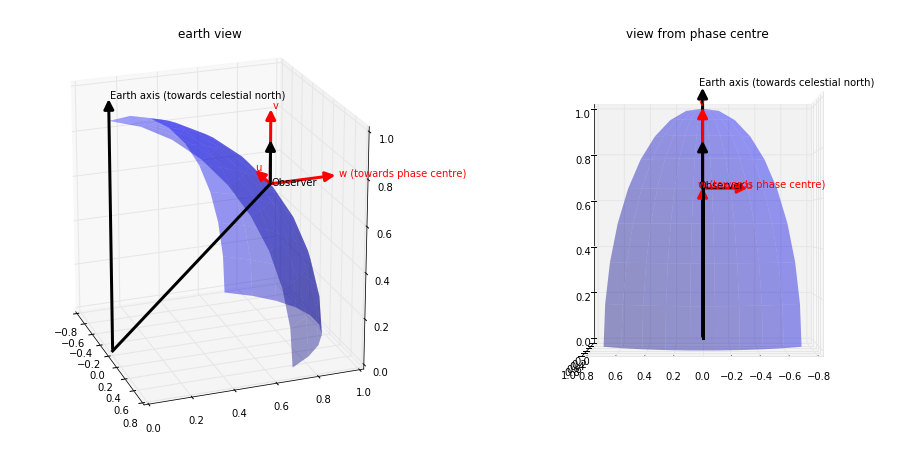

In [2]:
interact(visualise_uvw, latitude=(0,90,10), hour_angle=(-90,90,10), declination=(-90,90,10));

## 2. Local coordinates

For imaging, it is a good idea to express celestial directions relative to a certain "middle" position on the sky - conceptually the position that will appear in the middle of our image. This is called the phase tracking centre.

From this we derive the $(u,v,w)$ coordinate system, which is a local coordinate system with its origin at the observer's location (centre of the telescope). The axes are determined as follows:

1. $w$ points towards the phase tracking centre,

2. $v, w$ and the north celestial pole are always on a common plane and

3. $u$ completes a right-handed coordinate system (cross product of $v$ and $w$)

This has the following properties:

1. when the direction of observation is the north celestial pole (`hour_angle=0, declination=90`), the UVW coordinates are aligned with XYZ

2. when $w$ is on the local meridian (`hour_angle=0`), $u$ points East

4. when the direction of observation is at `declination=0`, `hour_angle=-90` makes $w$ point East.

(adapted from http://casa.nrao.edu/Memos/CoordConvention.pdf)

Here is an example of how we would translate the station coordinates of the VLA (http://www.vla.nrao.edu/) into the $(u,v,w)$ coordinate system appropriate for an observation:

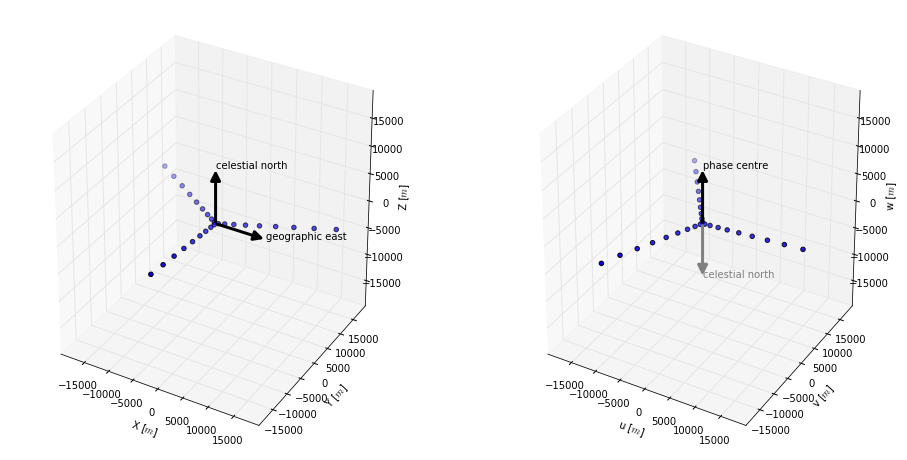

In [3]:
vlas = numpy.genfromtxt("../../data/models/VLA_A_hor_xyz.txt", delimiter=",")
size = np.amax(np.abs(np.ravel(vlas)))

def draw_transformed(latitude, hour_angle, declination):
    xyz = xyz_at_latitude(vlas, np.radians(latitude))
    uvws = xyz_to_uvw(xyz, np.radians(hour_angle), np.radians(declination))
    ncp = xyz_to_uvw(np.array([[0,0,10000]]), np.radians(hour_angle), np.radians(declination))
    
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(*np.transpose(xyz))
    ax.set_xlabel('X [$m$]'); ax.set_ylabel('Y [$m$]'); ax.set_zlabel('Z [$m$]')
    make_arrow(ax, [0,0,0], [10000,0,0], "black", "geographic east")
    make_arrow(ax, [0,0,0], [0,0,10000], "black", "celestial north")
    ax.set_xlim(-size,size); ax.set_ylim(-size,size); ax.set_zlim(-size,size)
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(*np.transpose(uvws))
    make_arrow(ax, [0,0,0], [0,0,10000], "black", "phase centre")
    make_arrow(ax, [0,0,0], ncp[0], "gray", "celestial north")
    ax.set_xlabel('u [$m$]'); ax.set_ylabel('v [$m$]'); ax.set_zlabel('w [$m$]')
    ax.set_xlim(-size,size); ax.set_ylim(-size,size); ax.set_zlim(-size,size)
    plt.show()
interact(draw_transformed, latitude=(-90,90,10), hour_angle=(-90,90,10), declination=(-90,90,10));

Note how the only observation where the target does not move with the hour angle is `latitude = +-90` and `declination = +-90`. This means we are observing from the earth's north/south pole straight up/down, which makes stations rotate around us in a common plane.

Of course, the hour angle is not constant along an observation due to the earth's rotation. For example, let us assume a 6 hour observation in which the hour angle of the phase centre goes from $-45°$ to $45°$. Then we get a distribution of station $(u,v,w)$ coordinates, depending on telescope latitude and phase centre declination:

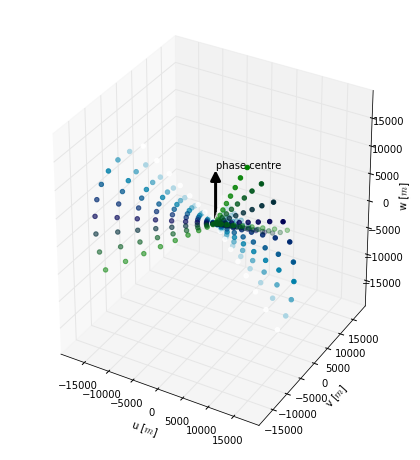

In [4]:
cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=-45,vmax=45), cmap=cm.ocean)
def draw_range(latitude, declination):
    xyz = xyz_at_latitude(vlas, np.radians(latitude))
    ax = plt.figure().add_subplot(121, projection='3d')
    for hour_angle in numpy.linspace(-45, 45, 10):
        
        # Determine rotated station UVWs
        uvws = xyz_to_uvw(xyz, np.radians(hour_angle), np.radians(declination))

        ax.scatter(*np.transpose(uvws), c=cmap.to_rgba(hour_angle), edgecolor=cmap.to_rgba(hour_angle))
    make_arrow(ax, [0,0,0], [0,0,10000], "black", "phase centre")
    ax.set_xlabel('u [$m$]'); ax.set_ylabel('v [$m$]'); ax.set_zlabel('w [$m$]')
    ax.set_xlim(-size,size); ax.set_ylim(-size,size); ax.set_zlim(-size,size)
    plt.show()
interact(draw_range, latitude=(-90,90,10), hour_angle=(-90,90,10), declination=(-90,90,10));

Observe that with `latitude = 0` multiple stations do not move at all. This is because the VLA layout would have a line of stations going in a straight south-north line if placed on the equator. Fortunately, that is not where it is actually located.

## 3. Baselines

For interferometry we derive data about the sky from the interference between station/antenna signals. Every such pair forms a _baseline_. The interference pattern measured for it largely depends on its length and orientation.

For every baseline there are two "directions" depending in whether we subtract the position of station 1 from the position of station 2 or the other way around. Imaging input will only contain one direction though, as the inverse baseline will simply have a complex-conjugate interference pattern. Below, we draw both directions anyway in order to highlight the symmetry.

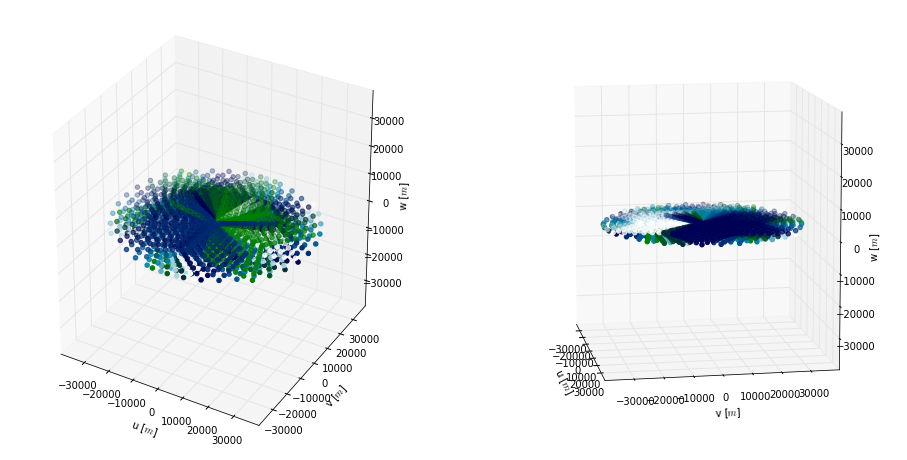

In [5]:
def draw_baselines(latitude, declination):
    xyz = xyz_at_latitude(vlas, np.radians(latitude))
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    for hour_angle in numpy.linspace(-45, 45, 10):

        # Determine rotated station UVWs, generate baselines from pairs
        uvws = xyz_to_uvw(xyz, np.radians(hour_angle), np.radians(declination))
        bls = baselines(uvws)
        
        ax.scatter(*np.transpose(bls), c=cmap.to_rgba(hour_angle), edgecolor=cmap.to_rgba(hour_angle))
        ax.scatter(*np.transpose(-bls), c=cmap.to_rgba(hour_angle), edgecolor=cmap.to_rgba(hour_angle))
    ax.set_xlabel('u [$m$]'); ax.set_ylabel('v [$m$]'); ax.set_zlabel('w [$m$]')
    ax.set_xlim(-2*size,2*size); ax.set_ylim(-2*size,2*size); ax.set_zlim(-2*size,2*size)
    ax = fig.add_subplot(122, projection='3d')
    for hour_angle in numpy.linspace(-45, 45, 10):

        # Determine rotated station UVWs, generate baselines from pairs
        uvws = xyz_to_uvw(xyz, np.radians(hour_angle), np.radians(declination))
        bls = baselines(uvws)
        
        ax.scatter(*np.transpose(bls), c=cmap.to_rgba(hour_angle), edgecolor=cmap.to_rgba(hour_angle))
        ax.scatter(*np.transpose(-bls), c=cmap.to_rgba(hour_angle), edgecolor=cmap.to_rgba(hour_angle))
    ax.set_xlabel('u [$m$]'); ax.set_ylabel('v [$m$]'); ax.set_zlabel('w [$m$]')
    ax.set_xlim(-2*size,2*size); ax.set_ylim(-2*size,2*size); ax.set_zlim(-2*size,2*size)
    ax.view_init(elev=10., azim=-10.)
    
    plt.show()
    
interact(draw_baselines, latitude=(-90,90,10), hour_angle=(-90,90,10), declination=(-90,90,10));